<a href="https://colab.research.google.com/github/HsiangHung/Machine_Learning_Note/blob/master/GNN_1_GCN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# GCN Demo

This demo notebook follows Juan Nathaniel's blog: [Understanding and Implementing Graph Neural Network](https://towardsdatascience.com/understanding-graph-neural-network-using-pytorch-geometric-c77a7ad76459).

This introduction shows how to define your own simple graphs, and how to build a simple graph neural network, constructing a two GCN layer deep model for multiclass classifcation problem, using PyTorch Geometric (PyG) library.

Table of Content:
* Installation
* Introduction to Graphs
* Constructing Simple Graphs using PyG
* Training and Evaluating Simple GNNs using PyG

**NOTE** Before implementing torch-geometric, we need to install it in this colab:

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 106 kB 4.1 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp38-cp38-linux_x86_64.whl size=477429 sha256=e904567245e6bf73d1b7a2530c115d4ed4e5fe6f9dff2e8de09f019b38f9e964
  Stored in directory: /root/.cache/pip/wheels/41/7f/4f/cf072bea3b6efe4561de2db3603ebbd8718c134c24caab8281
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 208 kB 4.1 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.16-cp38-cp38-linux_x86_64.whl size=984350 sha256=3351ed52ab0993eaa6cd93f00447371bc941711f17bfe9dcfb1a41e9b9aeb5ba
  Stored in directory: /root/.cache/pip/wheels/

## Prepare toy sample data using PyG

The following code is to prepare sample graph data:

1. edge_index: is a 2D array where the second dimension consists of 2 subarrays representing the Origin and Destination nodes (eg. node 0 $\to$ node 1, node 1 $\to$ node 0, node 1 $\to$ node 2, and node 2 $\to$ node 1). So we have first arry as origin nodes [0, 1, 1, 2] and second array as destination nodes [1, 0, 2, 1].
2. x: the value attributes of the three nodes $x = [-1, 0, 1]$.
3. Data: constructs the graph data structure when you provide the x attributes and edge_index.

To implement torch, we need to prepare data in class of `torch.tensor`:

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

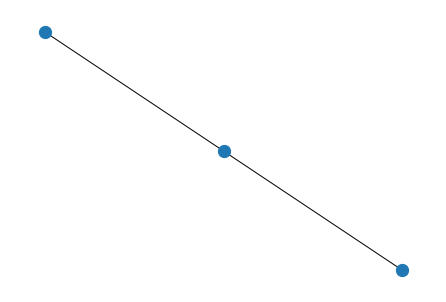

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)
nx.draw(G, node_size=150)

In [ ]:
# The number of nodes in the graph
data.num_nodes

3

In [ ]:
# The number of edges
data.num_edges

4

In [ ]:
# Number of attributes
data.num_node_features

1

In [ ]:
# If the graph contains any isolated nodes
data.contains_isolated_nodes()

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


False

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [ ]:
data.num_nodes, data.num_features

(2708, 1433)

In [ ]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

## Prepare multiclass classification GCN model

* Two GNN layers
* `relu` activation function
* `dropout`
* log softmax

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## Training and Evaluating Simple GCN using PyG

In [ ]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7910


## Prediction

In [ ]:
data.y.numpy()

array([3, 4, 4, ..., 3, 3, 3])

In [ ]:
pred.numpy()

array([3, 4, 4, ..., 0, 3, 3])